# Voting Feature Intervals (VFI)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

## Pre-processing

In [2]:
from lib import pre_processing
file_path = "./data/features_3_sec.csv"
df = pd.read_csv(file_path)
df = pre_processing(df)

## Data Normalization

In [3]:
from lib import normalize_df
df = normalize_df(df)

In [4]:
df_numpy = df.to_numpy()
X = df_numpy[:,:-1]
y = df_numpy[:, -1]

In [5]:
X.shape, y.shape

((9990, 57), (9990,))

## Mutliclass VFI

In [6]:
import vfi
from sklearn.model_selection import train_test_split

def fit_vfi(X, y, test_size):
    # Train-validation split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    # Fit the model
    vfi_model = vfi.VFI()
    vfi_model = vfi_model.fit(X_train, y_train)
    y_pred = vfi_model.predict(X_test)
    
    # Return the accuracy
    return ((y_test == y_pred).sum() / len(y_test))

In [7]:
accuracy_list = []
accuracy = fit_vfi(X, y, 0.33)
accuracy_list.append(accuracy*100)
print(f"| Genre: multiclass | Accuracy: {accuracy:.3%} |")

| Genre: multiclass | Accuracy: 47.953% |


## Balanced Binary Classifiers

We want classes to have the same number of elements.

Therefore, we will randomly select samples from the other classes.

In [8]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop','jazz', 'metal', 'pop', 'reggae', 'rock']

In [9]:
from lib import balance_classes
for genre in genres:
    Xi, yi = balance_classes(X, y, genre)
    accuracy = fit_vfi(Xi, yi, 0.33)
    accuracy_list.append(accuracy*100)
    print(f"| Genre: {genre:9} | Accuracy: {accuracy:.3%} |")

| Genre: blues     | Accuracy: 78.030% |
| Genre: classical | Accuracy: 90.440% |
| Genre: country   | Accuracy: 73.596% |
| Genre: disco     | Accuracy: 70.758% |
| Genre: hiphop    | Accuracy: 77.390% |
| Genre: jazz      | Accuracy: 78.939% |
| Genre: metal     | Accuracy: 83.182% |
| Genre: pop       | Accuracy: 86.818% |
| Genre: reggae    | Accuracy: 78.485% |
| Genre: rock      | Accuracy: 66.161% |


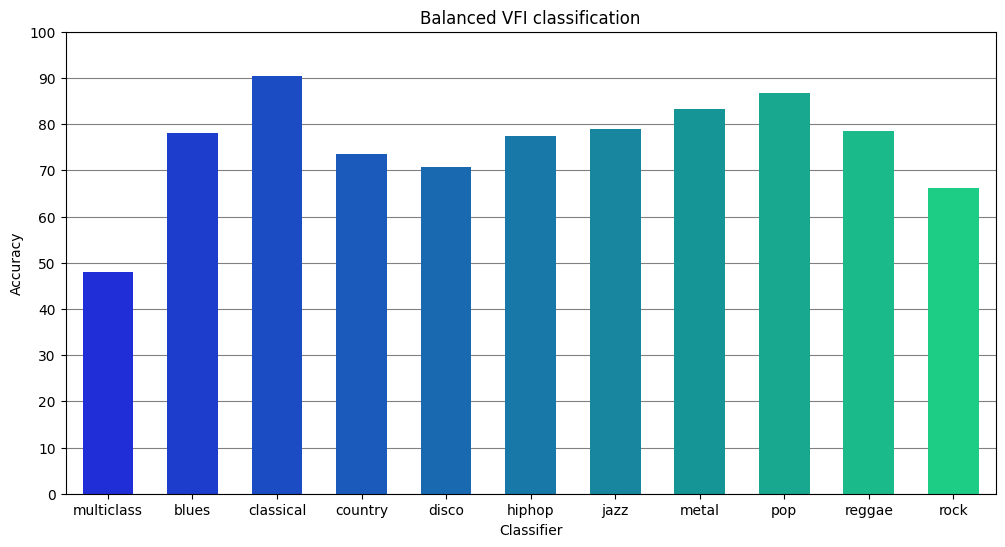

In [10]:
from lib import plot_accuracies
labels = ['multiclass'] + genres
plot_accuracies(labels, accuracy_list, "Balanced VFI classification")